Shape: (284807, 31)

Missing values:
 0

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Fraud Percentage: 0.1727%
Before SMOTE: Class
0    199020
1       344
Name: count, dtype: int64
After SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9931    0.9964     85295
           1     0.1784    0.8581    0.2953       148

    accuracy                         0.9929     85443
   macro avg     0.5891    0.9256    0.6459     85443
weighted avg     0.9983    0.9929    0.9952     85443

Confusion Matrix:
 [[84710   585]
 [   21   127]]
AUC Score: 0.9694
Optimal Threshold: 0.9628
Classification Report with Tuned Threshold:
               precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     85295
           1     0.8201    0.7703    0.7944       148

    accuracy                         0.9993     85443
   macro avg     0.9099    0.8850    0.8970     85443
weighted avg     0.9993    0.9993    0.9993     85443

Confusion Matrix:
 [[85270    25]
 [   34   114]]


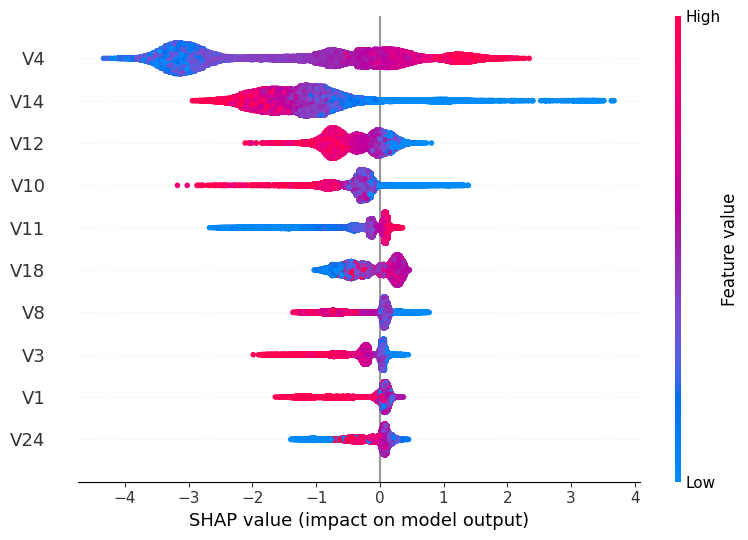

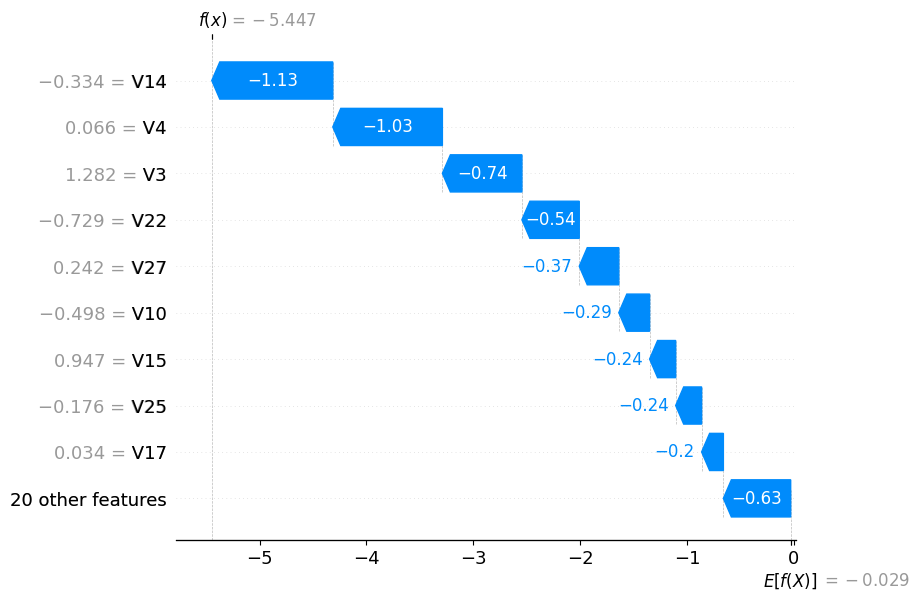

<Figure size 1000x600 with 0 Axes>

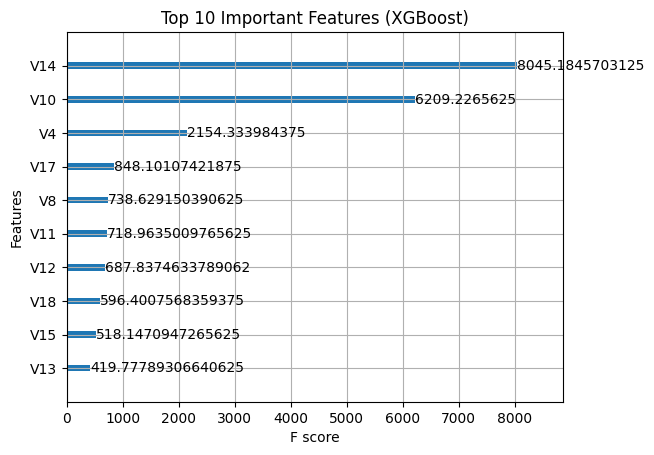

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import shap
import plotly.express as px
import xgboost as xgb_vis
import matplotlib.pyplot as plt



# Load the dataset (you've already done this)
df = pd.read_csv("//kaggle//input//creditcard//creditcard.csv")

# Basic info
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum().sum())

# Class distribution
print("\nClass distribution:\n", df['Class'].value_counts())

# Percentage of fraud transactions
fraud_percentage = (df['Class'].sum() / len(df)) * 100
print(f"\nFraud Percentage: {fraud_percentage:.4f}%")

# Drop Time and store 'Class' separately
df = df.drop(['Time'], axis=1)
X = df.drop('Class', axis=1)
y = df['Class']

# Scale 'Amount'
scaler = RobustScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


# Initialize SMOTE
sm = SMOTE(random_state=42)

# Fit on training data only
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Show new class distribution
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


# Define model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train with early stopping
xgb.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

# Predictions
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]


# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc:.4f}")

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the best threshold for a tradeoff (F1 score optimization)
best_idx = np.argmax(2 * (precision * recall) / (precision + recall))
best_threshold = thresholds[best_idx]
print(f"Optimal Threshold: {best_threshold:.4f}")

# Apply the threshold to predicted probabilities
y_pred_thresh = (y_proba >= best_threshold).astype(int)

# Evaluate new predictions
print("Classification Report with Tuned Threshold:\n", classification_report(y_test, y_pred_thresh, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))


# Create SHAP explainer
explainer = shap.Explainer(xgb)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Global summary plot (feature importance)
shap.summary_plot(shap_values, X_test, max_display=10)

# Pick an example fraud transaction
fraud_idx = y_test[y_test == 1].index[0]  # first fraud

# Force plot for individual explanation
shap.plots.waterfall(shap_values[fraud_idx])



# Add predicted probabilities to test set
test_data = X_test.copy()
test_data['Actual'] = y_test
test_data['Fraud_Prob'] = y_proba

# Only frauds
frauds = test_data[test_data['Actual'] == 1]

# Plot distribution
fig = px.histogram(frauds, x='Amount', nbins=40,
                   title='Fraud Transactions by Amount',
                   color_discrete_sequence=['indianred'])
fig.show()



plt.figure(figsize=(10,6))
xgb_vis.plot_importance(xgb, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (XGBoost)")
plt.show()

fig = px.histogram(test_data, x='Fraud_Prob',
                   nbins=50,
                   title='Fraud Probability Distribution (Risk Scores)',
                   color='Actual',
                   color_discrete_map={0: 'lightblue', 1: 'crimson'})
fig.show()

